This example shows how to:  
1. Load a counts matrix (10X Chromium data from human peripheral blood cells)
2. Run the default Scrublet pipeline 
3. Check that doublet predictions make sense

In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=14)
plt.rcParams['pdf.fonttype'] = 42

#### Load counts matrix and gene list
Load the raw counts matrix as a scipy sparse matrix with cells as rows and genes as columns.

In [3]:
input_dir = '/home/ubuntu/velocyto/Dec_trachea/P1_Dec11/mut2/P1_Dec11_mut_2/outs/filtered_gene_bc_matrices/mm10-1.2.0/'
counts_matrix = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
genes = np.array(scr.load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))

print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Counts matrix shape: 2253 rows, 27998 columns
Number of genes in gene list: 27998


#### Initialize Scrublet object
The relevant parameters are:
- *expected_doublet_rate*: the expected fraction of transcriptomes that are doublets, typically 0.05-0.1. Results are not particularly sensitive to this parameter. For this example, the expected doublet rate comes from the Chromium User Guide: https://support.10xgenomics.com/permalink/3vzDu3zQjY0o2AqkkkI4CC
- *sim_doublet_ratio*: the number of doublets to simulate, relative to the number of observed transcriptomes. This should be high enough that all doublet states are well-represented by simulated doublets. Setting it too high is computationally expensive. The default value is 2, though values as low as 0.5 give very similar results for the datasets that have been tested.
- *n_neighbors*: Number of neighbors used to construct the KNN classifier of observed transcriptomes and simulated doublets. The default value of `round(0.5*sqrt(n_cells))` generally works well.


In [4]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.02)

#### Run the default pipeline, which includes:
1. Doublet simulation
2. Normalization, gene filtering, rescaling, PCA
3. Doublet score calculation 
4. Doublet score threshold detection and doublet calling


In [5]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 10.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.2%
Elapsed time: 3.2 seconds


#### Plot doublet score histograms  for observed transcriptomes and simulated doublets
The simulated doublet histogram is typically bimodal. The left mode corresponds to "embedded" doublets generated by two cells with similar gene expression. The right mode corresponds to "neotypic" doublets, which are generated by cells with distinct gene expression (e.g., different cell types) and are expected to introduce more artifacts in downstream analyses. Scrublet can only detect neotypic doublets.  
  
To call doublets vs. singlets, we must set a threshold doublet score, ideally at the minimum between the two modes of the simulated doublet histogram. `scrub_doublets()` attempts to identify this point automatically and has done a good job in this example. However, if automatic threshold detection doesn't work well, you can adjust the threshold with the `call_doublets()` function. For example:
```python
scrub.call_doublets(threshold=0.25)
```

/home/ubuntu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


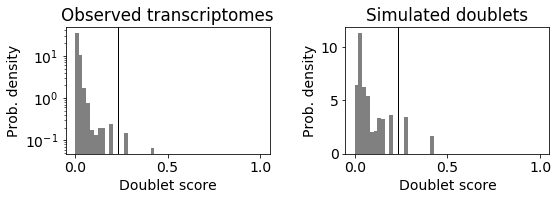

In [6]:
scrub.plot_histogram();

#### Get 2-D embedding to visualize the results

In [7]:
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

# # Uncomment to run tSNE - slow
# print('Running tSNE...')
# scrub.set_embedding('tSNE', scr.get_tsne(scrub.manifold_obs_, angle=0.9))

# # Uncomment to run force layout - slow
# print('Running ForceAtlas2...')
# scrub.set_embedding('FA', scr.get_force_layout(scrub.manifold_obs_, n_neighbors=5. n_iter=1000))
    
print('Done.')

Running UMAP...


/home/ubuntu/.local/lib/python2.7/site-packages/numba/errors.py:104: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


Done.


#### Plot doublet predictions on 2-D embedding
Predicted doublets should co-localize in distinct states.

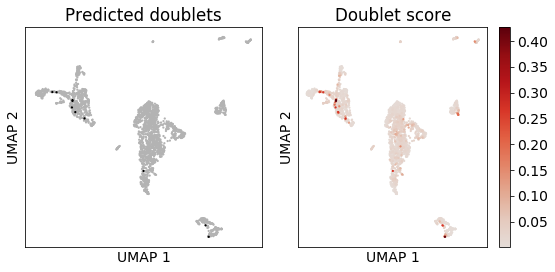

In [8]:
scrub.plot_embedding('UMAP', order_points=True);

# scrub.plot_embedding('tSNE', order_points=True);
# scrub.plot_embedding('FA', order_points=True);

In [9]:
print(doublet_scores)

[0.01474531 0.0106562  0.00690926 ... 0.00859889 0.00617284 0.02355072]


In [10]:
print(predicted_doublets)

[False False False ... False False False]


In [11]:
sum(predicted_doublets)

10

In [12]:
len(predicted_doublets)

2253

In [13]:
cwd = os.getcwd()
print (cwd)

/home/ubuntu/scrublet/examples


In [14]:
doublet_scores.tofile('P1_Dec11_mut_2_doubletScore.csv',sep=',',format='%s')

In [15]:
min(doublet_scores[predicted_doublets])

0.2686567164179108